# Rainfall - Climate Hazards Group InfraRed Precipitation with Station data (CHIRPS)

* **Products used:** 
[rainfall_chirps_monthly](https://explorer.digitalearth.africa/products/rainfall_chirps_monthly)


## Background

This notebook demonstrates how to access and use the **Monthly Climate Hazards Group InfraRed Precipitation with Station data (CHIRPS)** from the DE Africa Open Data Cube. 

For offical information on this dataset, see [CHIRPS](https://www.chc.ucsb.edu/data/chirps). The abstract from this documentation is copied below:

    Estimating rainfall variations in space and time is a key aspect of drought early warning and environmental monitoring. An evolving drier-than-normal season must be placed in a historical context so that the severity of rainfall deficits can be quickly evaluated. However, estimates derived from satellite data provide areal averages that suffer from biases due to complex terrain, which often underestimate the intensity of extreme precipitation events. Conversely, precipitation grids produced from station data suffer in more rural regions where there are less rain-gauge stations. CHIRPS was created in collaboration with scientists at the USGS Earth Resources Observation and Science (EROS) Center in order to deliver complete, reliable, up-to-date data sets for a number of early warning objectives, like trend analysis and seasonal drought monitoring.

The current CHIRPS dataset that is accessible from DE Africa's platforms is the `CHIRPS-2.0 Africa Monthly` dataset, copied from [here](https://data.chc.ucsb.edu/products/CHIRPS-2.0/africa_monthly/tifs/), converted to cloud-opitmized geotiffs, and indexed into DE Africa's Open-Data-Cube.

**Important specifications:**

* Datacube product name: `rainfall_chirps_monthly`
* Measurement Type: Monthly Atmospheric Precipitation
* Precipitation Units: Total mm/month
* Date-range: `1981-01` to `2021-07`
* Spatial resolution: 0.05 degrees, approximately 5.55 km



## Description

In this notebook we will load CHIRPS data using `dc.load()` to return a time series of datasets.

Topics covered include:
1. Inspecting the monthly CHIRPS product and measurements available in the datacube
2. Using the native `dc.load()` function to load CHIRPS data
3. Facet plotting the CHIRPS datasets
4. Conduct a simple analysis workflow: finding the long-term monthly mean rainfall

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages

Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import datacube
from matplotlib import pyplot as plt
from deafrica_tools.plotting import display_map

/env/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


### Connect to the datacube

In [2]:
dc = datacube.Datacube(app="rainfall_chirps")

### Analysis parameters

This section defines the analysis parameters, including 

* `lat, lon, buffer`: center lat/lon and analysis window size for the area of interest
* `time_period`: time period to be investigated
* `output_crs`: projection for loading data; output resolution is not defined so different resolutions can be used for Landsat and Sentinel-2

The default location cover all of Nigeria

In [3]:
lat, lon =  9.4707, 8.3899 

buffer_lat, buffer_lon = 6, 6

time_period = ('2020')

output_crs = 'epsg:6933'

#join lat,lon,buffer to get bounding box
lon_range = (lon - buffer_lon, lon + buffer_lon)
lat_range = (lat + buffer_lat, lat - buffer_lat)

## View the selected location

The next cell will display the selected area on an interactive map. Feel free to zoom in and out to get a better understanding of the area you'll be analysing. Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [4]:
display_map(lon_range, lat_range)

## Available products and measurements

### List products

We can use datacube's `list_products` functionality to inspect the CHIRPS rainfall datasets available in the datacube. The table below shows the product names that we will use to load the data and a brief description of the data

In [5]:
dc.list_products().loc[dc.list_products()['name'].str.contains('chirps')]

,name,description,license,default_crs,default_resolution
name,,,,,
rainfall_chirps_monthly,rainfall_chirps_monthly,Rainfall Estimates from Rain Gauge and Satelli...,None,EPSG:4326,"(-0.05000000074505806, 0.05000000074505806)"


### List measurements

We can further inspect the data available for CHIRPS using datacube's `list_measurements` functionality. The table below lists each of the measurements available in the data.

In [6]:
measurements = dc.list_measurements()
measurements.loc["rainfall_chirps_monthly"]

,name,dtype,units,nodata,aliases,flags_definition
measurement,,,,,,
rainfall,rainfall,float32,mm,-9999.0,NaN,NaN


## Load CHIRPS data using `dc.load()`

Now that we know what products and measurements are available for the products, we can load data from the datacube using `dc.load`. 

In the first example below, we will load CHIRPS data for region covering Nigeria

> Note: For a more general discussion of how to load data using the datacube, refer to the [Introduction to loading data](../Beginners_guide/03_Loading_data.ipynb) notebook.

In [7]:
ds_rf = dc.load(product='rainfall_chirps_monthly',
                time='2020',
                y = lat_range,
                x = lon_range,
                resolution=(-5000, 5000),
                output_crs=output_crs)

print(ds_rf)

<xarray.Dataset>
Dimensions:      (time: 12, x: 232, y: 303)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-16T11:59:59.500000 ... 2020-12...
  * y            (y) float64 1.952e+06 1.948e+06 ... 4.475e+05 4.425e+05
  * x            (x) float64 2.325e+05 2.375e+05 ... 1.382e+06 1.388e+06
    spatial_ref  int32 6933
Data variables:
    rainfall     (time, y, x) float32 0.0 0.0 0.0 ... 79.18779 76.52623 79.77302
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref


## Plotting CHIRPS Monthly Rainfall

Let's facet plot the time-series to see the total rainfall each month during 2020 over Nigeria.

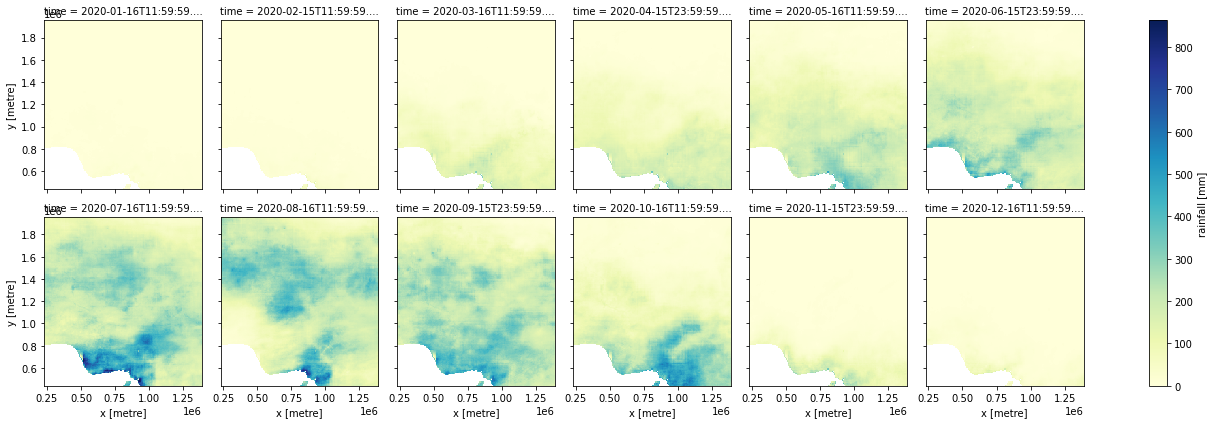

In [8]:
# set -9999 no-data values to NaN
ds_rf = ds_rf.where(ds_rf !=-9999.)

#facet plot rainfall
ds_rf['rainfall'].plot.imshow(col='time', col_wrap=6, cmap='YlGnBu', label=False);

## Example application: finding the monthly mean rainfall over a region

The following section will demonstrate a simple analysis workflow based on CHIRPS rainfall. We will use a 10-year time-series of rainfall over Nigeria to find the long-term monthly mean rainfall total.

First we will load the data, the parameters here are the same as the example above only we've increased to time-range from one year to 10 years.

In [9]:
ds_rf = dc.load(
    product="rainfall_chirps_monthly",
    time=('2010', '2010'),
    y=lat_range,
    x=lon_range,
    resolution=(-5000, 5000),
    output_crs=output_crs,
)

print(ds_rf)

<xarray.Dataset>
Dimensions:      (time: 12, x: 232, y: 303)
Coordinates:
  * time         (time) datetime64[ns] 2010-01-16T11:59:59.500000 ... 2010-12...
  * y            (y) float64 1.952e+06 1.948e+06 ... 4.475e+05 4.425e+05
  * x            (x) float64 2.325e+05 2.375e+05 ... 1.382e+06 1.388e+06
    spatial_ref  int32 6933
Data variables:
    rainfall     (time, y, x) float32 0.0 0.0 0.0 ... 47.229477 51.054344
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref


### Find the long-term monthly mean rainfall

We find the mean rainfall across the region (`ds_rf.mean(['x', 'y'])`), then we group all the same months together and find the mean of the all the January's, February's etc. (`groupby('time.month').mean()`). Lastly we convert the result to a pandas dataframe (`.drop('spatial_ref').to_dataframe()`) to faciliate the plotting of a bar-chart

In [10]:
# set -9999 no-data values to NaN
ds_rf = ds_rf.where(ds_rf !=-9999.)

#find the mean
ds_rf_mean = ds_rf.mean(['x', 'y']).groupby('time.month').mean().drop('spatial_ref').to_dataframe()
ds_rf_mean.head()

,rainfall
month,
1,3.978808
2,11.398681
3,25.605333
4,62.055168
5,109.535042


### Plot the result

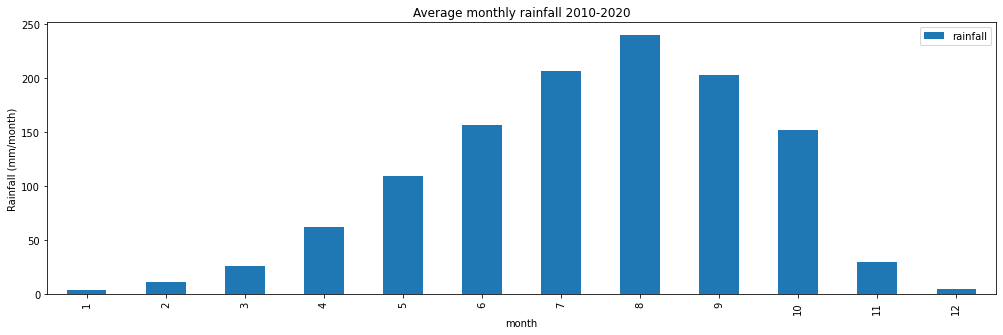

In [11]:
ds_rf_mean.plot.bar(figsize=(17,5))
plt.title('Average monthly rainfall 2010-2020')
plt.ylabel('Rainfall (mm/month)');

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [12]:
print(datacube.__version__)

1.8.5


**Last Tested:**

In [13]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-09-29'